In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='/home/mlut/IDLCV/dtu/datasets1/02516/hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

In [39]:
#######Fatemeh: ignore it

size = 128

import albumentations as albu
from albumentations.pytorch import ToTensorV2

# trainset_aug = Hotdog_NotHotdog(train=True, transform=None)
# train_loader_aug = DataLoader(trainset_aug, batch_size=64, shuffle=True, num_workers=3)
# foo, _ = next(iter(train_loader_aug))
# print(foo)

# Define a list of augmentations
train_transform = albu.Compose([
    albu.RandomResizedCrop(height=128, width=128, scale=(0.8, 1.0)),
    albu.HorizontalFlip(p=0.5),
    albu.RandomBrightnessContrast(p=0.2),
    albu.RandomGamma(p=0.2),
    albu.GaussNoise(p=0.2),
    albu.Rotate(limit=30, p=0.5),
    albu.RandomBrightness(p=0.2),
    albu.RandomContrast(p=0.2),
    albu.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

test_transform = albu.Compose([
    albu.Resize(height=128, width=128),
    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])
 
batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=None)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

/home/mlut/.conda/envs/bipolardata/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/mlut/.conda/envs/bipolardata/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/mlut/.conda/envs/bipolardata/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/mlut/.conda/envs/bipolardata/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/mlut/.conda/envs/bipolardata/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_291928/3660485875.py", line 22, in __getitem__
    X = self.transform(image)
  File "/home/mlut/.conda/envs/bipolardata/lib/python3.10/site-packages/albumentations/core/composition.py", line 193, in __call__
    raise KeyError("You have to pass data to augmentations as named arguments, for example: aug(image=image)")
KeyError: 'You have to pass data to augmentations as named arguments, for example: aug(image=image)'


In [4]:
from torchvision import transforms

size = 128

# Augmented training transformations
train_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomRotation(10),      # Randomly rotate the images by 10 degrees
    transforms.RandomCrop(size, padding=10),  # Randomly crop a portion of the image
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, saturation, and hue
    transforms.ToTensor()
])

# Test transformations (without data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor()
])

batch_size = 64

# Load the augmented training dataset
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)

# Load the test dataset (without augmentation)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

foo, _ = next(iter(test_loader))
# print(foo.unsqueeze(1))

# print(target.unsqueeze(1))

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [49]:
#size = 128
#train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    # transforms.ToTensor()])


#test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    # transforms.ToTensor()])

                                    

#batch_size = 64
#trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
#train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
#testset = Hotdog_NotHotdog(train=False, transform=test_transform)
#test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

Let's look at some images from our data 

torch.Size([64, 3, 128, 128])
tensor([[[[0.3216, 0.3333, 0.3451,  ..., 0.0000, 0.0000, 0.0000],
          [0.3255, 0.3333, 0.3451,  ..., 0.0000, 0.0000, 0.0000],
          [0.3137, 0.3294, 0.3451,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.3412, 0.3529, 0.3647,  ..., 0.0000, 0.0000, 0.0000],
          [0.3451, 0.3529, 0.3647,  ..., 0.0000, 0.0000, 0.0000],
          [0.3412, 0.3529, 0.3647,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.2078, 0.2078, 0.2118,  ..., 0.0000, 0.0000, 0.0000],
          [0.2039, 0.2078, 0.2157,  ..., 0.0000, 0.0000, 0.0000],
          [0

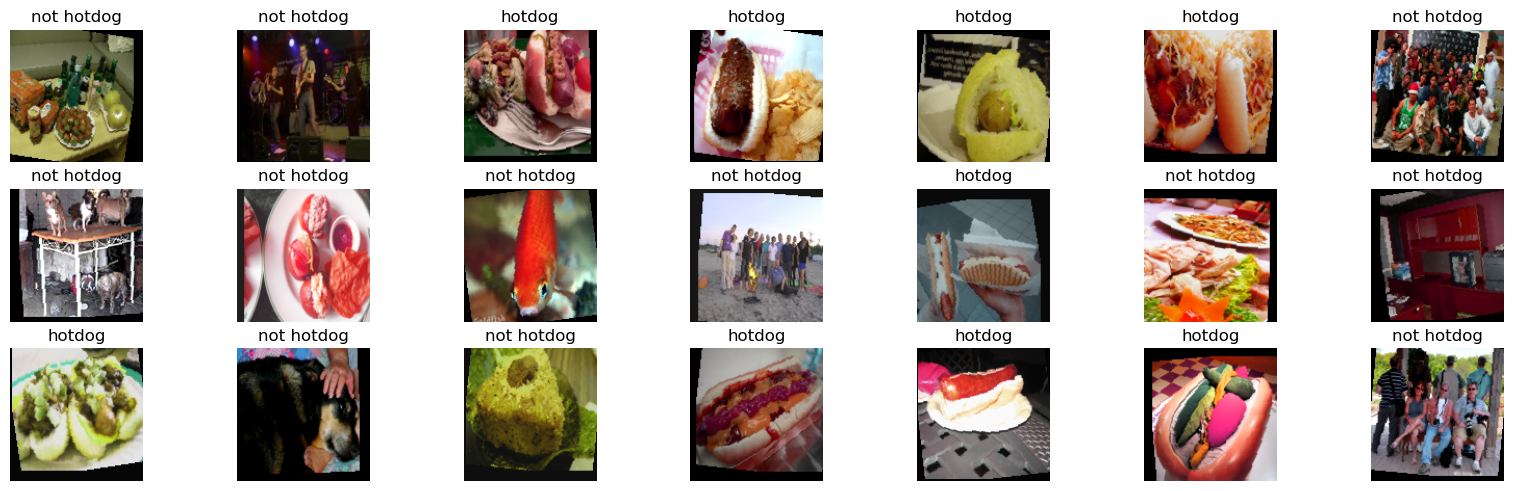

In [6]:
images, labels = next(iter(train_loader))
print(images.shape) #(64,3,128,128) ? 
print(images)
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Remember to save the state of your model AND optimizer regularly in case the Colab runtime times out.
You can save your model to your google drive, so you can get it from there in a new colab session. 

If you only save it in the colab notebook, there's no way to get it into a new session.

In [9]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Now create a model and train it!


In [5]:
class Network02(nn.Module):
    def __init__(self):
        super(Network02, self).__init__()
        self.convolutional = nn.Sequential(
                nn.Conv2d(3, 2**3, kernel_size=3, padding=0), #127
                nn.ReLU(),
                # nn.MaxPool2d(2, stride=2), #127/2 = 63
                nn.Conv2d(2**3, 2**4, kernel_size=3, padding=0), # 126
                nn.BatchNorm2d(2**4), #should return 62 ?? 
                nn.ReLU()
        )

        self.fully_connected = nn.Sequential(
                nn.Linear(16*124*124, 124*124),
                nn.ReLU(),
                nn.Linear(124*124, 500),
                nn.ReLU(),
                nn.Linear(500, 250),
                nn.ReLU(),
                nn.Linear(250, 125),
                nn.ReLU(),
                nn.Linear(125, 1)
        )
        # self.sigmoid = 
    def forward(self, x):
        x = self.convolutional(x)        
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        # x = nn.F.sigmoid(x)
        # x = nn.Softmax(dim=1)(x)
        return x

In [42]:
class Network03(nn.Module):
    def __init__(self):
        super(Network03, self).__init__()
        self.convolutional = nn.Sequential(
                nn.Conv2d(3, 2**3, kernel_size=3, padding=0), #start with a resolution of 128, after conv, 126
                nn.Conv2d(2**3, 2**4, kernel_size=3, padding=0), # 126 input, output 124,
                #nn.ReLU()
                nn.MaxPool2d(2, stride=2), #max pool, leaves 62 
                nn.BatchNorm2d(2**4), 
                nn.ReLU()
        )

        self.fully_connected = nn.Sequential(
                nn.Linear(16*62*62, 124*124),
                nn.ReLU(),
                nn.Linear(124*124, 500),
                nn.ReLU(),
                nn.Linear(500, 250),
                nn.ReLU(),
                nn.Linear(250, 125),
                nn.ReLU(),
                nn.Linear(125, 1)
        )
        # self.sigmoid = 
    def forward(self, x):
        x = self.convolutional(x)        
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        # x = nn.F.sigmoid(x)
        # x = nn.Softmax(dim=1)(x)
        return torch.sigmoid(x)

In [6]:
class Network04(nn.Module):
    def __init__(self):
        super(Network04, self).__init__()

        self.convolutional = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=0),
            nn.BatchNorm2d(num_features=32),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0),
            nn.BatchNorm2d(num_features=64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0),
            nn.BatchNorm2d(num_features=128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        self.fully_connected = nn.Sequential(
            nn.Linear(in_features=128 * 61 * 61, out_features=512), 
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=128, out_features=1)
        )

    def forward(self, x):
        x = self.convolutional(x)        
        x = x.view(x.size(0), -1)  
        x = self.fully_connected(x)
        return x



In [15]:
model = Network04()
model.to(device)
#Initialize the optimizer
optimizer_sgd = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.0001) ## REDUCED another one

#Get the first minibatch
data = next(iter(train_loader))[0].cuda()
print(data.shape)
# Try running the model on a minibatch
print('Shape of the output from the convolutional part', model.convolutional(data).shape)
model(data); #if this runs the model dimensions fit
print("model works with one minibatch")

torch.Size([64, 3, 128, 128])
Shape of the output from the convolutional part torch.Size([64, 128, 61, 61])
model works with one minibatch


In [16]:
#MARTIN IS PLAYING
optimizer = optimizer_adam
num_epochs = 5
loss_function = nn.BCEWithLogitsLoss()

for epoch in tqdm(range(num_epochs), unit='epoch'):
    model.train()  
    train_correct = 0
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output.squeeze(), target.float())  
        loss.backward()
        optimizer.step()
        predicted = (output > 0).float()  # Connverts logits to 0s and 1s
        train_correct += (target == predicted.squeeze()).sum().item()

    model.eval()  # Set the model to evaluation mode
    test_correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            predicted = (output > 0).float()  # Convert logits to 0s and 1s
            test_correct += (target == predicted.squeeze()).sum().item()

    train_acc = train_correct / len(trainset)
    test_acc = test_correct / len(testset)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Accuracy: {train_acc*100:.1f}%, Test Accuracy: {test_acc*100:.1f}%")


  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/5, Train Accuracy: 61.4%, Test Accuracy: 65.6%


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/5, Train Accuracy: 60.1%, Test Accuracy: 71.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/5, Train Accuracy: 65.5%, Test Accuracy: 69.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/5, Train Accuracy: 64.1%, Test Accuracy: 70.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/5, Train Accuracy: 64.5%, Test Accuracy: 72.2%


In [13]:
optimizer = optimizer_adam
num_epochs = 5
loss_function = nn.BCEWithLogitsLoss()

for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_correct = 0
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer.zero_grad()
        #Forward pass your image through the network
        output = model(data)
        
        #Compute the loss
        # output = output.view(output.size(0), -1)
        # output = output[0]
        # print(output.shape)
        # print(target.shape)
        # print(torch.log(output))
        # loss = F.nll_loss(torch.log(output), target)
        # loss = F.binary_cross_entropy(output, target)
        loss = loss_function(output, target.unsqueeze(1).float())
        #Backward pass through the network
        loss.backward()
        #Update the weights
        optimizer.step()
        
        #Compute how many were correctly classified
        predicted = (output > 0).float() #predicted = output.argmax(1) ## THIS IS WRONG; 
        train_correct += (target == predicted.squeeze()).sum().item() #train_correct += (target==predicted).sum().cpu().item()
    #Comput the test accuracy
    test_correct = 0
    for data, target in test_loader:
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
        predicted = (output > 0).float() ## also changed here from argmax
        test_correct += (target==predicted).sum().item()
    train_acc = train_correct/len(trainset)
    test_acc = test_correct/len(testset)
    print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))

  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

<h1>Salient Maps</h1>

In [8]:
X = next(iter(train_loader))[0].to(device)
model = Network02()
# we would run the model in evaluation mode
model.to(device)
model.eval()


print(X[0].shape)
# we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
# X.requires_grad_()

'''
forward pass through the model to get the scores, note that VGG-19 model doesn't perform softmax at the end
and we also don't need softmax, we need scores, so that's perfect for us.
'''

#scores = model(X)
#print(scores)

# # Get the index corresponding to the maximum score and the maximum score itself.
# score_max_index = scores.argmax()
# score_max = scores[0,score_max_index]

# '''
# backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
# score_max with respect to nodes in the computation graph
# '''
# score_max.backward()

# '''
# Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
# R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
# across all colour channels.
# '''
# saliency, _ = torch.max(X.grad.data.abs(),dim=1)
# # saliency.to('cpu')

# # code to plot the saliency map as a heatmap
# plt.imshow(saliency[0], cmap=plt.cm.hot)
# plt.axis('off')
# plt.show()

torch.Size([3, 128, 128])


"\nforward pass through the model to get the scores, note that VGG-19 model doesn't perform softmax at the end\nand we also don't need softmax, we need scores, so that's perfect for us.\n"

Saliency maps